In [2]:
from datetime import datetime
from elasticsearch import Elasticsearch, helpers
import numpy as np
import pandas as pd
import pprint
from __future__ import division
from __future__ import print_function
from datetime import datetime
import calendar
from zipfile import ZipFile
import os
import sys
import dateutil
import zipfile


%matplotlib inline

import numpy as np
import pandas as pd
import math
import pprint
from __future__ import division
from __future__ import print_function
from datetime import datetime
import matplotlib.pyplot as plt
import os
from fractions import Fraction 
import scipy.odr.odrpack as odrpack
import time
from bisect import bisect_left
import datetime as dt
import matplotlib.dates as mdates
import calendar
from sklearn import preprocessing


es = Elasticsearch(['atlas-kibana.mwt2.org:9200'])

## Functions

In [9]:
def collect_and_clean_byIP_Scroll(es, src_data, dest_data, timeframe, saveToDisk = True):
    '''
    This will collect raw data from elastic search for the connection from a source, to a given destination.
    Within the given timeframe.
    The resulting data is returned and by can be as well wirtten to disk (default).
    '''
    print("--- Starting data collection for {} to {}, in the time of {} to {}".format(
            src_data['name'], dest_data['name'], timeframe["gte"], timeframe["lt"]))
    data = pd.DataFrame()
    es_query = \
    {
        "query": {
                    "bool": {
                        "must":[
                            { 'term': { 'src': src_data["latency"] } },
                            { 'term': { 'dest': dest_data["latency"] } },
                            { 'range': { 'timestamp': timeframe } }
                        ]
                    }
                }
    }
    es_index = "network_weather-*"
    
    # Collect latency raw data
    event_type = 'latency'
    scroll = list(helpers.scan(client=es, query=es_query, index=es_index, doc_type=event_type, request_timeout=6000))
    count = 0
    for dataPoint in scroll:
        count += 1
        #time = dateutil.parser.parse(dataPoint['_source']['timestamp'])
        #timestamp_epoch = calendar.timegm(time.timetuple())
        timestamp_epoch = dataPoint['_source']['timestamp']/1000
        data.set_value(timestamp_epoch, 'delay_median', dataPoint['_source']['delay_median'])
        data.set_value(timestamp_epoch, 'delay_avg', dataPoint['_source']['delay_mean'])
        data.set_value(timestamp_epoch, 'delay_sd', dataPoint['_source']['delay_sd'])
    print('Number of raw records of {} is {}'.format(event_type, count))
    
    # Collect packet_loss_rate raw data
    event_type = 'packet_loss_rate'
    scroll = list(helpers.scan(client=es, query=es_query, index=es_index, doc_type=event_type, request_timeout=6000))
    count = 0
    for dataPoint in scroll:
        count += 1
        #time = dateutil.parser.parse(dataPoint['_source']['timestamp'])
        #timestamp_epoch = calendar.timegm(time.timetuple())
        timestamp_epoch = dataPoint['_source']['timestamp']/1000
        data.set_value(timestamp_epoch, 'packet_loss', dataPoint['_source']['packet_loss'])
    print('Number of raw records of {} is {}'.format(event_type, count))
    
    # rebuilding our query
    es_query = \
    {
        "query": {
                    "bool": {
                        "must":[
                            { 'term': { 'src': src_data["throughput"] } },
                            { 'term': { 'dest': dest_data["throughput"] } },
                            { 'range': { 'timestamp': timeframe } }
                        ]
                    }
            }
    }
    
    # Collect throughput raw data
    event_type = 'throughput'
    scroll = list(helpers.scan(client=es, query=es_query, index=es_index, doc_type=event_type, request_timeout=6000))
    count = 0
    for dataPoint in scroll:
        count += 1
        #time = dateutil.parser.parse(dataPoint['_source']['timestamp'])
        #timestamp_epoch = calendar.timegm(time.timetuple())
        timestamp_epoch = dataPoint['_source']['timestamp']/1000
        #data.set_value(timestamp_epoch, 'throughput', dataPoint['_source']['throughput'])
    print('Number of raw records of {} is {}'.format(event_type, count))
    print(" ")
    
    # View statistics of raw_data_pool (already de-duplicated)
    print()
    print('De-duplication result:')
    print(data.count(axis='index'))
    
    # Sort in-place
    data.sort_index(inplace=True, ascending=False)
    
    # Store this DataFrame to disk file
    if saveToDisk:
        print("Saving results to disk.")
        print("")
        data.to_pickle('raw_data/raw_data_by_IP_from_{}_to_{}_and_time_{}_to_{}_sorted.pkl'.format(src_data['name'], dest_data['name'], timeframe["gte"], timeframe["lt"]))
    
    # return the data
    return data


In [89]:
# smir out data
def smoothDataFrame(data, steps):
    # make sure that there are no nans! This would brick the cumsum function!
    # This may happen naturally when the packet_loss is at 1, so no packets get through
    # for simplicity we will drop those lines    
    data_smired = data.copy(deep=True)
    if "packet_loss" in data_smired.axes[1]:
        data_smired = data_smired.dropna(axis=0, subset=["delay_avg"])
    for col in data_smired.axes[1]:
        # do NOT smir our "throughput_perfSonar"
        if col == "throughput_perfSonar":
            continue
        vals = data_smired[col].values
        valsSumed = np.cumsum(vals)
        for i in range(steps, len(data_smired)):
            summ = valsSumed[i] - valsSumed[i-steps]
            vals[i] = summ/steps
        vals[:steps] = float('nan')
        data_smired[col] = vals
    # make sure not to use the first values, which were not averaged, e.g. delete them
    data_smired = data_smired.drop(data_smired.index[:steps])
    return data_smired

## Getting the data

In [90]:
# read our raw data
data_router = pd.read_pickle("raw_data_routers/bak10_raw_router_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_highres.pkl")
data_perfSonar = pd.read_pickle("raw_data_routers/raw_toolkit_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_sorted.pkl")

# data processing
# smooth data
steps = 3
data_router = smoothDataFrame(data_router, steps)
steps = 15
for key1 in data_perfSonar.keys():
    for key2 in data_perfSonar[key1]:
        for key3 in data_perfSonar[key1][key2]:
            # smir the data
            data_perfSonar[key1][key2][key3] = smoothDataFrame(data_perfSonar[key1][key2][key3], steps)
            # add the gradient for delay_avg and packetloss
            data_perfSonar[key1][key2][key3]['delay_avg_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['delay_avg'], edge_order=2)
            data_perfSonar[key1][key2][key3]['packet_loss_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['packet_loss'], edge_order=2)
       
# make dates for the plots
dates_router = []
for stamp in data_router.index:
    dates_router.append(dt.datetime.fromtimestamp(stamp))
    
dates_perfSonar = {}
for src in data_perfSonar:
    dates_perfSonar[src] = {}
    for dest in data_perfSonar[src]:
        dates_perfSonar[src][dest] = {}
        for direction in data_perfSonar[src][dest]:
            dates_perfSonar[src][dest][direction] = []
            for stamp in data_perfSonar[src][dest][direction].index:
                dates_perfSonar[src][dest][direction].append(dt.datetime.fromtimestamp(stamp))
                

In [10]:
CERN_data = {'name': "CERN", "latency": "128.142.223.247", "throughput": "128.142.223.246"}
RAL_data = {'name': "RAL", "latency": "130.246.176.109", "throughput": "130.246.176.110"}
PIC_data = {'name': "PIC", "latency": "193.109.172.188", "throughput": "193.109.172.187"}
TRIUMF_data = {'name': "TRIUMF", "latency": "206.12.9.2", "throughput": "206.12.9.1"}
BNL_data = {'name': "BNL", "latency": "192.12.15.26", "throughput": "192.12.15.23"}
KIT_data = {'name': "KIT", "latency": "192.108.47.12", "throughput": "192.108.47.6"}

out_points_list = [RAL_data, PIC_data, TRIUMF_data, BNL_data, KIT_data]

timeframe = { 'gte': '2016-09-11', 'lt': '2016-09-27' }
es_data = collect_and_clean_byIP_Scroll(es, TRIUMF_data, CERN_data, timeframe, saveToDisk=False)

# smooth data
steps = 3
es_data_smothed = smoothDataFrame(es_data, steps)

# create dates
dates_es_data = []
for stamp in es_data_smothed.index:
    dates_es_data.append(dt.datetime.fromtimestamp(stamp))


--- Starting data collection for TRIUMF to CERN, in the time of 2016-09-11 to 2016-09-27


RequestError: TransportError(400, 'search_phase_execution_exception', 'failed to parse date field [2016-09-11] with format [basic_date_time_no_millis||epoch_millis]')

## Plotting the data

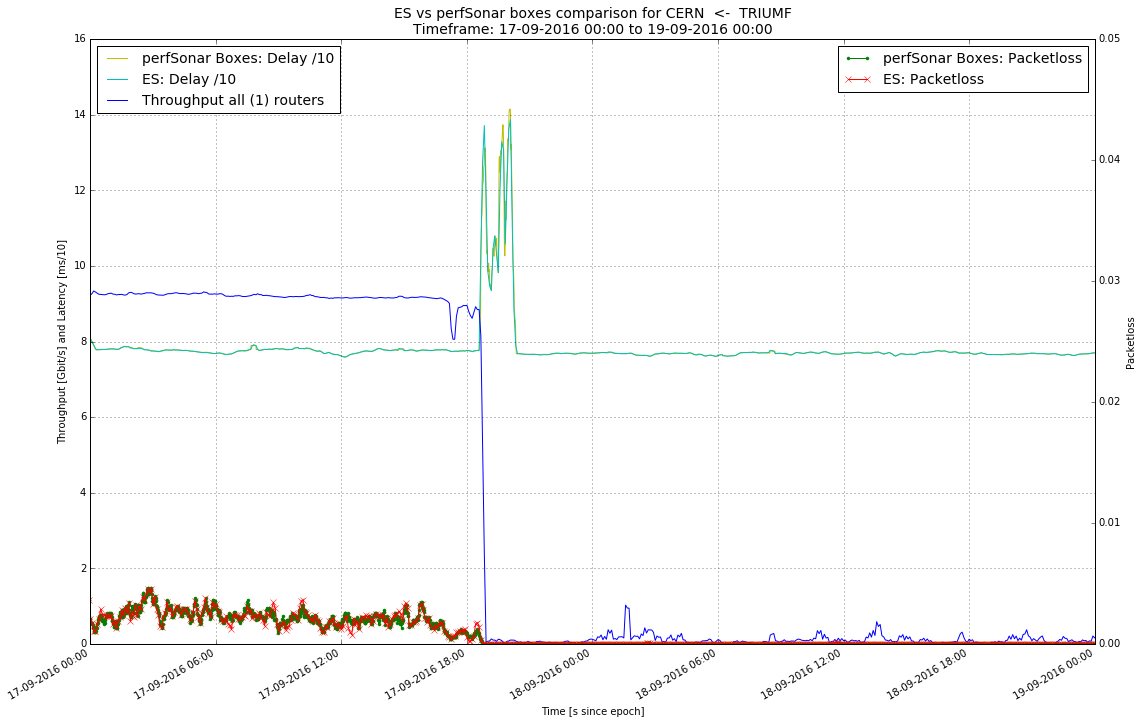

In [102]:
# plot stuff
timeframe = ['17-09-2016 00:00', '19-09-2016 00:00']
src = "CERN"
dest = "TRIUMF"
direction = "in"
savePath=''
#savePath = 'plots/router_multi_plots_2016-09-28/'


# set stuff up
direction_counter = "in"
if direction == "in":
    direction_counter = "out"
dirMarker = " <- "
if direction == "out":
    dirMarker = " -> "
title = "ES vs perfSonar boxes comparison for "+src+" "+dirMarker+" "+dest +"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])
fname = title
# plot the data we got
fig, ax1 = plt.subplots()
fig.set_size_inches(18,12)
fig.set_dpi(300)
plt.title(title,fontsize=14)

# make first axis
ax1.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["delay_avg"]/10,
         'y', label=r'perfSonar Boxes: Delay /10')
ax1.plot(dates_es_data, es_data_smothed["delay_avg"]/10,
         'c', label=r'ES: Delay /10')
# get throughput
throughputs = []
for router in data_router.axes[1]:
    if dest in router and direction in router[len(router)-3:]:
        throughputs.append(data_router[router])
combinded_throughput = sum(throughputs)
ax1.plot(dates_router, combinded_throughput/1e9,
         'b', label=r'Throughput all ('+str(len(throughputs))+') routers')


# make second axis
ax2 = ax1.twinx()
ax2.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["packet_loss"],
         'g.-', label=r'perfSonar Boxes: Packetloss')
ax2.plot(dates_es_data, es_data_smothed["packet_loss"],
         'rx-', label=r'ES: Packetloss')

# limits
#ax1.set_ylim([0, 20])
ax2.set_ylim([0, 0.05])
plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
plt.gcf().autofmt_xdate()
# legends and lables
ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
ax1.set_xlabel("Time [s since epoch]")
ax1.legend(loc='upper left',fontsize=14)
ax2.set_ylabel("Packetloss")
ax2.legend(loc='upper right',fontsize=14)
ax1.grid(True, which='major')
# saving?
if savePath != '' :
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()